In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import qutip as qt
from qutip_qip.operations import gate_sequence_product
from qutip_qip.circuit import CircuitSimulator
from time import process_time

#necessary to avoid a Tensorflow issue on my PC
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import sys
print (sys.version)
# 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
import tensorflow as tf
print("Tensorflow version: "+tf.__version__)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

3.7.13 (default, Oct 19 2022, 10:19:43) [MSC v.1916 64 bit (AMD64)]
Tensorflow version: 2.9.1
Num GPUs Available:  0


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import basis, fidelity
from qutip_qip.device import LinearSpinChain
from qutip_qip.algorithms import qft_gate_sequence

def gate_apply(gate,state_vector,data_type=tf.float32,normalize=False)
    '''Function which converts gates and state vector into desired precision, then multiplies them. 
    The output state vector is recast into a QuTiP quantum object.'''
    real_gate = tf.cast(np.real(gate.full()),dtype=data_type)
    imag_gate = tf.cast(np.imag(gate.full()),dtype=data_type)
    
    real_state = tf.cast(np.real(state_vector.full()),dtype=data_type)
    imag_state = tf.cast(np.imag(state_vector.full()),dtype=data_type)
    
    real_final_state = tf.tensordot(real_gate,real_state,axes=1)-tf.tensordot(imag_gate,imag_state,axes=1)
    imag_final_state = tf.tensordot(imag_gate,real_state,axes=1)+tf.tensordot(real_gate,imag_state,axes=1)
    
    final_state = qt.Qobj(real_final_state.numpy()+1j*imag_final_state.numpy(),dims=state_vector.dims)
    
    if normalize = True:
        final_state = final_state.unit()
    
    return final_state

# Start the stopwatch / counter
t1_start = process_time()
# Set the Number of Qubits
num_qubits = 10
# Initial State
int_state = basis([2]*num_qubits, [0]*num_qubits)
# The QFT circuit
qc = qft_gate_sequence(num_qubits, swapping=False, to_cnot=True)
# sets the number of times to repeat the circuit (e.g. repeat=1 means the circuit is repeated once, for 2 total applications
# of the circuit)
repeat = 10
for i in range(repeat):
    qc.add_circuit(qft_gate_sequence(num_qubits, swapping=False, to_cnot=True))
# Gate-level simulation
state1 = qc.run(int_state)
# Pulse-level simulation
#processor = LinearSpinChain(num_qubits)
#processor.load_circuit(qc)
#state2 = processor.run_state(int_state).states[-1]
#print(fidelity(state1, state2))

gates = qc.propagators()
print('Number of total gates: '+str(len(gates)))

# Stop the stopwatch / counter
t1_stop = process_time()
print("Elapsed time during QuTiP circuit simulation in seconds:", t1_stop-t1_start) 

SyntaxError: invalid syntax (1091544609.py, line 7)

In [91]:
#This codeblock just checks that the function gate_apply works as intended for all precisions by multiplying all gates
#together first, then calling gate_apply using that matrix and the initial state. Since there won't be any error propogation
#throughout the circuit, we expect all of these fidelities to be close to 1 (although lower for smaller precisions).

# Start the stopwatch / counter
t2_start = process_time()

for precision in [tf.complex128,tf.complex64,tf.float64,tf.float32,tf.float16,tf.bfloat16]:
    precision_string = str(precision)[str(precision).find(' ')+2:-2]
    final_state = gate_apply(gate_sequence_product(gates),int_state,precision)
    print("Fidelity for percision "+precision_string+" is "+str(fidelity(final_state,state1)))
    
# Stop the stopwatch / counter
t2_stop = process_time()
print("Elapsed time during Final State fidelity check across precisions in seconds:", t2_stop-t2_start)

Fidelity for percision complex128 is 1.0000007696243436
Fidelity for percision complex64 is 1.000000626074178
Fidelity for percision float64 is 1.0000007696243436
Fidelity for percision float32 is 1.000000626074178
Fidelity for percision float16 is 1.0001636898142336
Fidelity for percision bfloat16 is 1.0011358119313187
Elapsed time during Final State fidelity check across precisions in seconds: 536.953125


In [92]:
# This codeblock tracks the state vector evolution after every gate application using QuTiP's native simulation engine. 
# We will use this series of state vectors to compare our results to using different precisions.

# Start the stopwatch / counter
t2_start = process_time()

#set up baseline using QuTIP native simulation
sim = CircuitSimulator(qc, state=int_state)
state_vector = int_state
vector_list_baseline = []
vector_list_baseline.append(state_vector)
for i in range(len(gates)):
    state_vector = sim.step()
    vector_list_baseline.append(state_vector)
qt.qsave(vector_list_baseline, 'vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat))

# Stop the stopwatch / counter
t2_stop = process_time()
print("Elapsed time during baseline state vector evolution in seconds:", t2_stop-t2_start) 

Elapsed time during baseline state vector evolution in seconds: 4.453125


In [57]:
#set up baseline w/ highest percision
#precision_baseline = tf.complex128
#state_vector = int_state
#vector_list_baseline = []
#vector_list_baseline.append(state_vector)
#for index,gate in enumerate(gates):
#    state_vector = gate_apply(gate,state_vector,data_type=precision)
#    vector_list_baseline.append(state_vector)
# need to edit the filename if the precision changes
#qt.qsave(vector_list_baseline, 'vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision_baseline)[str(precision_baseline).find('complex'):-2])

In [93]:
# As above, this codeblock keeps track of the state vector evolution throughout the circuit, but this time using the specified
# precisions. Each result is saved as a QuTiP file to be accessed later without having to redo calculations.

# Start the stopwatch / counter
t2_start = process_time()

#set up test w/ different percision
precisions_to_test = [tf.complex128,tf.complex64,tf.float64,tf.float32,tf.float16,tf.bfloat16]
for precision in precisions_to_test:
    vector_list = []
    state_vector = int_state
    vector_list.append(state_vector)
    for gate in gates:
        state_vector = gate_apply(gate,state_vector,data_type=precision)
        vector_list.append(state_vector)
    filename = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]
    qt.qsave(vector_list,filename)
    
# Stop the stopwatch / counter
t2_stop = process_time()
print("Elapsed time during test state vector evolution in seconds:", t2_stop-t2_start)

Elapsed time during test state vector evolution in seconds: 717.078125


Elapsed time during fidelity plotting evolution in seconds: 30681.4375


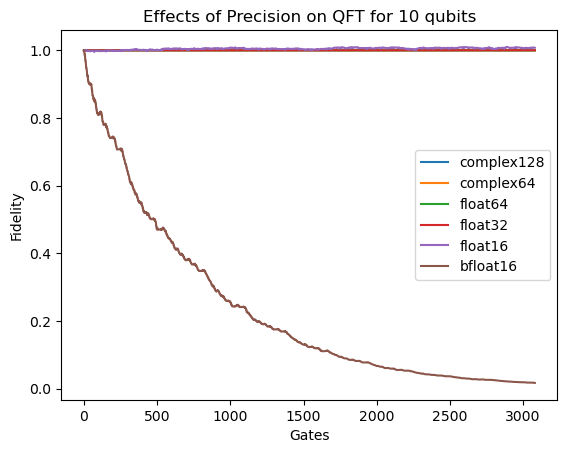

In [94]:
# Computes, then plots the fidelity of each state vector at every precision vs. the baseline.

normalize = True
# Start the stopwatch / counter
t2_start = process_time()

vector_list_baseline = qt.qload('vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat))
if normalize = True:
    for index, state_vector in enumerate(vector_list_baseline):
        vector_list_baseline[index] = vector_list_baseline[index].unit() # normalize statevector
fig = plt.figure()
for precision in precisions_to_test:
    loadname = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]
    savename = 'fidelity_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]
    precision_string = str(precision)[str(precision).find(' ')+2:-2]
    vector_list = qt.qload(loadname)
    fidelity_list = []
    for i in range(len(vector_list)):
        fidelity_list.append(fidelity(vector_list[i],vector_list_baseline[i]))
    qt.qsave(fidelity_list,savename)   
    plt.plot(fidelity_list,label=precision_string)
plt.title('Effects of Precision on QFT for '+str(num_qubits)+' qubits')
plt.xlabel('Gates')
plt.ylabel('Fidelity')
plt.legend()
fig.savefig('Effects of Precision on QFT for '+str(num_qubits)+' qubits'+'.jpg')

# Stop the stopwatch / counter
t2_stop = process_time()
print("Elapsed time during fidelity plotting evolution in seconds:", t2_stop-t2_start)

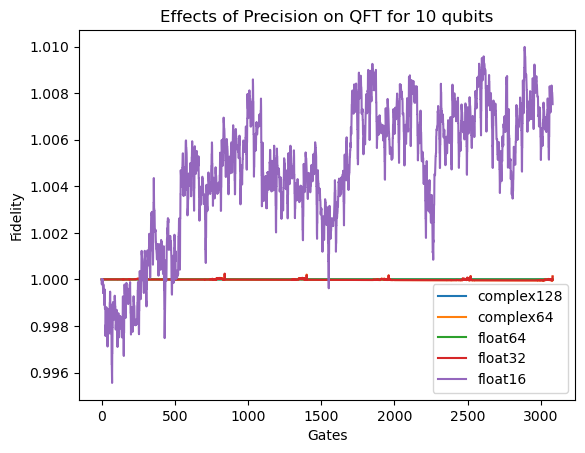

In [101]:
#load_num_qubits = num_qubits
#load_repeat = repeat
load_num_qubits = 10
load_repeat = 10
for precision in [tf.complex128,tf.complex64,tf.float64,tf.float32,tf.float16]:
    loadname = 'fidelity_list_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]
    precision_string = str(precision)[str(precision).find(' ')+2:-2]
    fidelity_list = qt.qload(loadname)
    plt.plot(fidelity_list,label=precision_string)
plt.title('Effects of Precision on QFT for '+str(num_qubits)+' qubits')
plt.xlabel('Gates')
plt.ylabel('Fidelity')
plt.legend()
fig.savefig('Effects of Precision on QFT for '+str(num_qubits)+' qubits'+'.jpg')

In [105]:
float16_state_vectors = qt.qload('vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_precision_'+str(tf.float16)[str(tf.float16).find(' ')+2:-2])
print(fidelity(float16_state_vectors[-1],state1))
print(fidelity(state1,vector_list_baseline[-1]))



1.0075245763813314
1.0000007696243436


In [62]:
sim = CircuitSimulator(qc, state=int_state)
fidelity(sim.step(),float16_state_vectors[1])

0.9998931902221827

In [122]:
count = 0
for i in range(len(float16_state_vectors)):
    if float16_state_vectors[i].unit() != float16_state_vectors[i]:
        count += 1
print(count)
print(len(float16_state_vectors))
(float16_state_vectors[100].unit()).norm()

3079
3081


0.9999999999999999

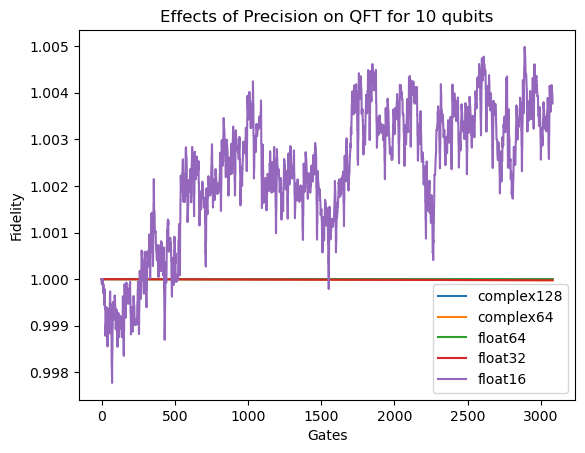

In [123]:
#load_num_qubits = num_qubits
#load_repeat = repeat
load_num_qubits = 10
load_repeat = 10
for precision in [tf.complex128,tf.complex64,tf.float64,tf.float32,tf.float16]:
    loadname = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]
    precision_string = str(precision)[str(precision).find(' ')+2:-2]
    state_vector_list = qt.qload(loadname)
    for index,state_vector in enumerate(state_vector_list):
        state_vector_list[index] = state_vector_list[index].norm()
    plt.plot(state_vector_list,label=precision_string)
plt.title('Effects of Precision on QFT for '+str(num_qubits)+' qubits')
plt.xlabel('Gates')
plt.ylabel('Fidelity')
plt.legend()
fig.savefig('Effects of Precision on QFT for '+str(num_qubits)+' qubits'+'.jpg')